# Exploratory Data Analysis (EDA) for Object Detection Dataset

This notebook performs comprehensive analysis of the dataset including:
- Sample image visualization
- Class distribution analysis
- Classes per image statistics
- Class co-occurrence patterns
- Image size distribution

In [1]:
# Import required libraries
import sys
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import cv2

# Add parent directory to path to import data_loader
sys.path.append(os.path.join(os.getcwd(), '..'))
from data.data_loader import DataLoader

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Configuration and Dataset

In [2]:
# Load configuration
config_path = os.path.join('..', 'config', 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully!")
print(f"Project: {config['robowflow']['project']}")
print(f"Version: {config['robowflow']['version']}")

Configuration loaded successfully!
Project: playingcarddetection-tea12-whczv
Version: 1


In [3]:
# Initialize DataLoader
data_loader = DataLoader(config)

# Download dataset
dataset = data_loader.download_dataset(format='yolov8')


loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Load all splits
print("Loading images from all splits...")
train_data, valid_data, test_data = data_loader.load_images()

print(f"\nDataset Statistics:")
print(f"Training images: {len(train_data)}")
print(f"Validation images: {len(valid_data)}")
print(f"Test images: {len(test_data)}")
print(f"Total images: {len(train_data) + len(valid_data) + len(test_data)}")

# Get class names
class_names = data_loader.get_class_names()
print(f"\nNumber of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading images from all splits...

Dataset Statistics:
Training images: 699
Validation images: 151
Test images: 150
Total images: 1000

Number of classes: 52
Classes: ['10C', '10D', '10H', '10S', '2C', '2D', '2H', '2S', '3C', '3D', '3H', '3S', '4C', '4D', '4H', '4S', '5C', '5D', '5H', '5S', '6C', '6D', '6H', '6S', '7C', '7D', '7H', '7S', '8C', '8D', '8H', '8S', '9C', '9D', '9H', '9S', 'AC', 'AD', 'AH', 'AS', 'JC', 'JD', 'JH', 'JS', 'KC', 'KD', 'KH', 'KS', 'QC', 'QD', 'QH', 'QS']


## 2. Sample Image Visualization

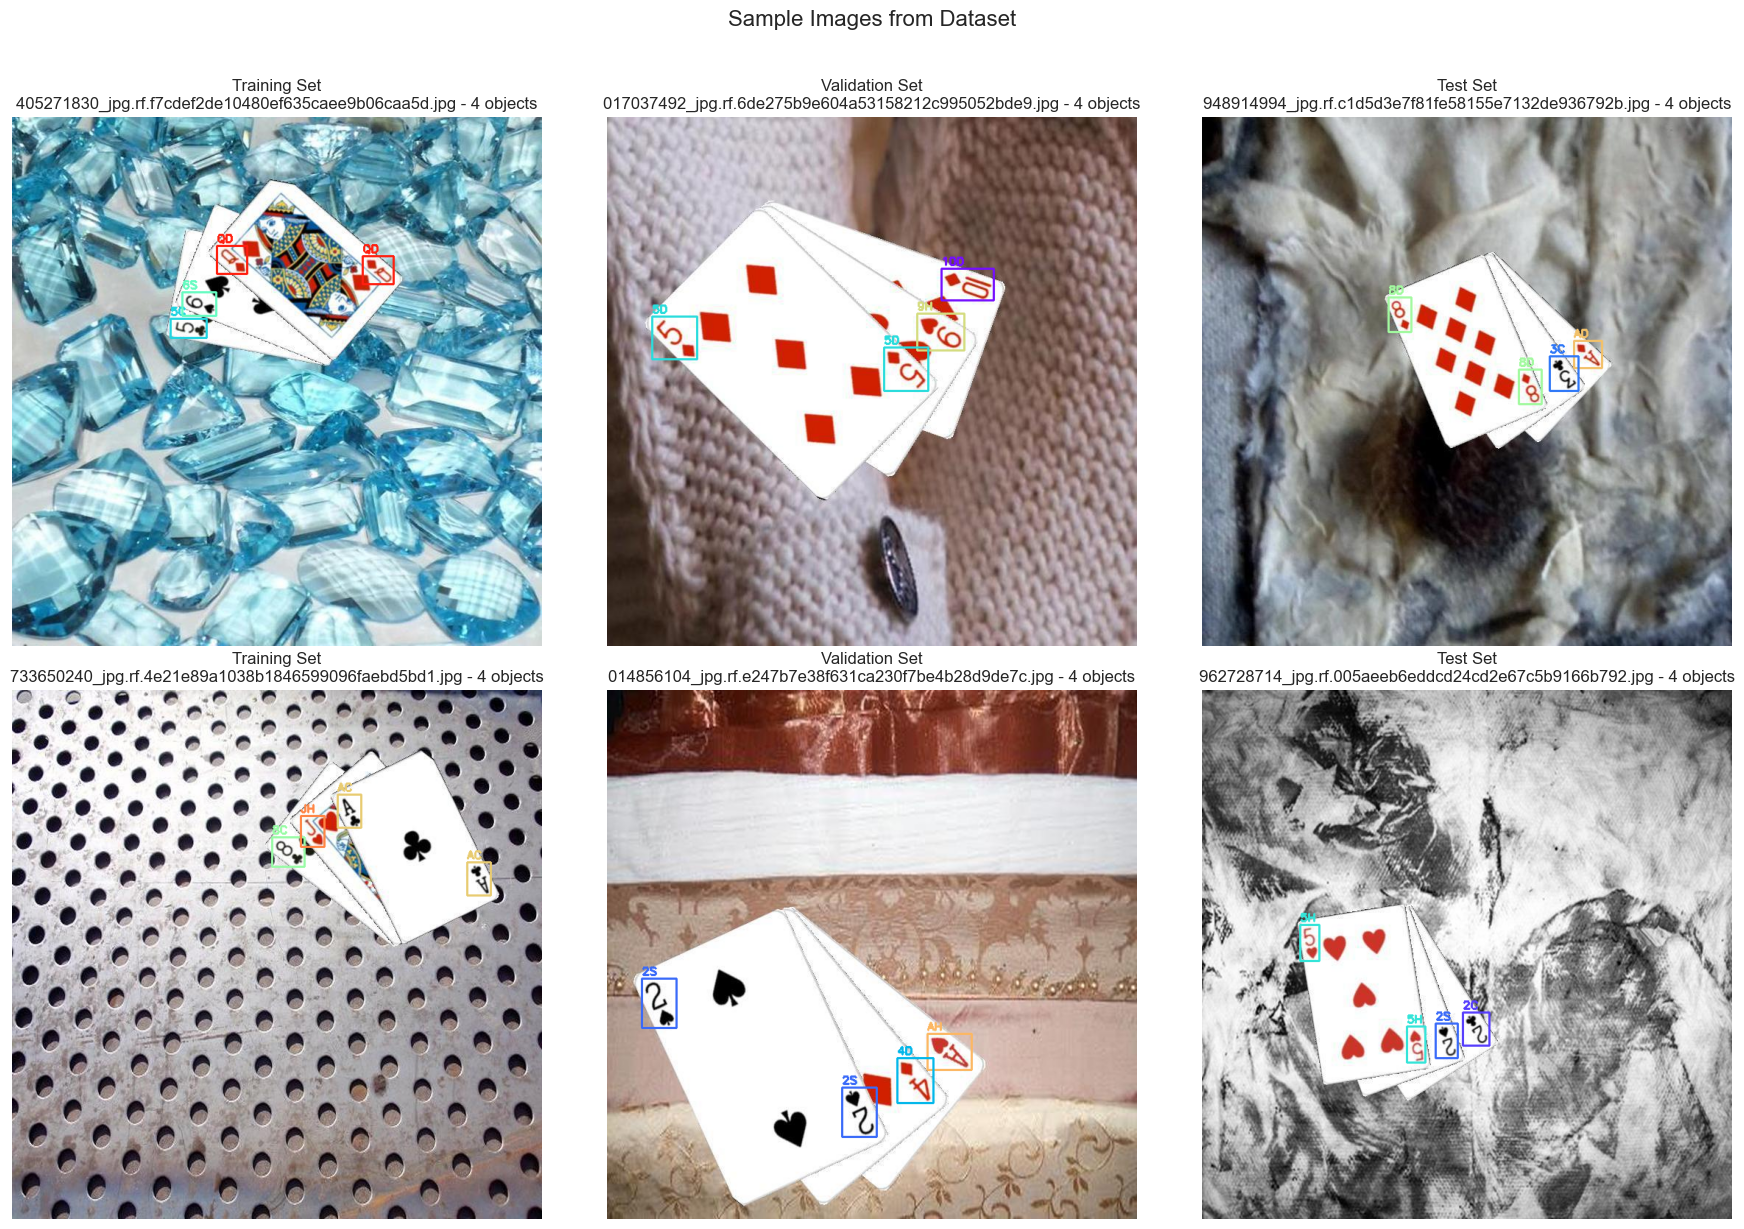

In [5]:
def parse_yolo_labels(label_path, img_width, img_height):
    """Parse YOLO format labels and convert to pixel coordinates"""
    if not os.path.exists(label_path):
        return []
    
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height
                
                # Convert to x1, y1, x2, y2
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                boxes.append((class_id, x1, y1, x2, y2))
    return boxes

def visualize_sample(data_item, class_names, title=""):
    """Visualize a single image with bounding boxes"""
    img = data_item['image'].copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    boxes = parse_yolo_labels(data_item['label_path'], w, h)
    
    # Draw bounding boxes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
    for class_id, x1, y1, x2, y2 in boxes:
        color = tuple(int(c * 255) for c in colors[class_id][:3])
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        label = class_names[class_id]
        cv2.putText(img, label, (x1, y1 - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    plt.imshow(img)
    plt.title(f"{title}\n{data_item['filename']} - {len(boxes)} objects")
    plt.axis('off')
    return img, boxes

# Show sample images from each split
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sample Images from Dataset', fontsize=16, y=1.02)

splits = [('Training', train_data), ('Validation', valid_data), ('Test', test_data)]
for col, (split_name, split_data) in enumerate(splits):
    if len(split_data) > 0:
        # Show 2 random samples per split
        samples = np.random.choice(len(split_data), min(2, len(split_data)), replace=False)
        for row, idx in enumerate(samples):
            plt.sca(axes[row, col])
            visualize_sample(split_data[idx], class_names, f"{split_name} Set")

plt.tight_layout()
plt.show()

## 3. Class Distribution Analysis

In [6]:
def count_classes_in_split(split_data, class_names):
    """Count instances of each class in a dataset split"""
    class_counts = Counter()
    
    for data_item in split_data:
        if data_item['label_path'] and os.path.exists(data_item['label_path']):
            with open(data_item['label_path'], 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
    
    return class_counts

# Count classes in each split
train_classes = count_classes_in_split(train_data, class_names)
valid_classes = count_classes_in_split(valid_data, class_names)
test_classes = count_classes_in_split(test_data, class_names)

# Create DataFrame for visualization
class_df = pd.DataFrame({
    'Class': class_names,
    'Train': [train_classes.get(i, 0) for i in range(len(class_names))],
    'Validation': [valid_classes.get(i, 0) for i in range(len(class_names))],
    'Test': [test_classes.get(i, 0) for i in range(len(class_names))]
})

class_df['Total'] = class_df['Train'] + class_df['Validation'] + class_df['Test']
class_df = class_df.sort_values('Total', ascending=False)

print("Class Distribution Summary:")
print(class_df)

Class Distribution Summary:
   Class  Train  Validation  Test  Total
13    4D     65          18    19    102
49    QD     66          19    16    101
29    8D     63          18    17     98
16    5C     59          17    17     93
11    3S     64          17    11     92
43    JS     67           7    16     90
27    7S     66          16     7     89
39    AS     67          14     8     89
15    4S     58          17    12     87
10    3H     56          11    19     86
30    8H     65           8    13     86
25    7D     65          13     8     86
37    AD     66          12     7     85
14    4H     65          12     8     85
4     2C     54           9    22     85
6     2H     59           7    19     85
7     2S     58           8    17     83
22    6H     66          10     7     83
31    8S     54          14    14     82
35    9S     51          13    18     82
51    QS     49          21    11     81
46    KH     63          11     7     81
3    10S     58          11  

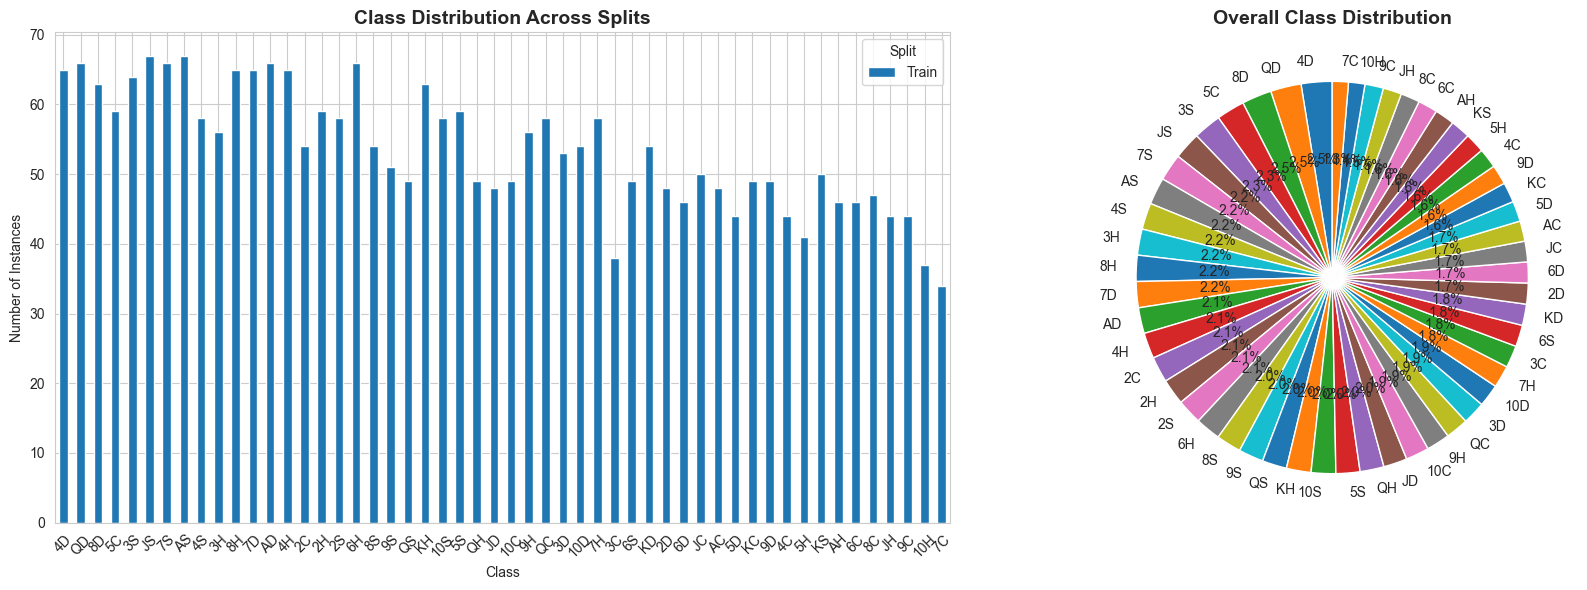

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot
class_df_plot = class_df.set_index('Class')[['Train']]
class_df_plot.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Instances')
axes[0].legend(title='Split')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart for total distribution
class_df_total = class_df.set_index('Class')['Total']
axes[1].pie(class_df_total, labels=class_df_total.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Classes per Image Analysis

In [8]:
def count_objects_per_image(split_data):
    """Count number of objects in each image"""
    counts = []
    
    for data_item in split_data:
        if data_item['label_path'] and os.path.exists(data_item['label_path']):
            with open(data_item['label_path'], 'r') as f:
                count = len(f.readlines())
                counts.append(count)
        else:
            counts.append(0)
    
    return counts

# Get object counts per image
train_obj_counts = count_objects_per_image(train_data)
valid_obj_counts = count_objects_per_image(valid_data)
test_obj_counts = count_objects_per_image(test_data)

# Calculate statistics
stats_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Mean': [np.mean(train_obj_counts), np.mean(valid_obj_counts), np.mean(test_obj_counts)],
    'Median': [np.median(train_obj_counts), np.median(valid_obj_counts), np.median(test_obj_counts)],
    'Min': [np.min(train_obj_counts), np.min(valid_obj_counts), np.min(test_obj_counts)],
    'Max': [np.max(train_obj_counts), np.max(valid_obj_counts), np.max(test_obj_counts)],
    'Std': [np.std(train_obj_counts), np.std(valid_obj_counts), np.std(test_obj_counts)]
})

print("\nObjects per Image Statistics:")
print(stats_df.to_string(index=False))


Objects per Image Statistics:
     Split  Mean  Median  Min  Max  Std
     Train   4.0     4.0    4    4  0.0
Validation   4.0     4.0    4    4  0.0
      Test   4.0     4.0    4    4  0.0


The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


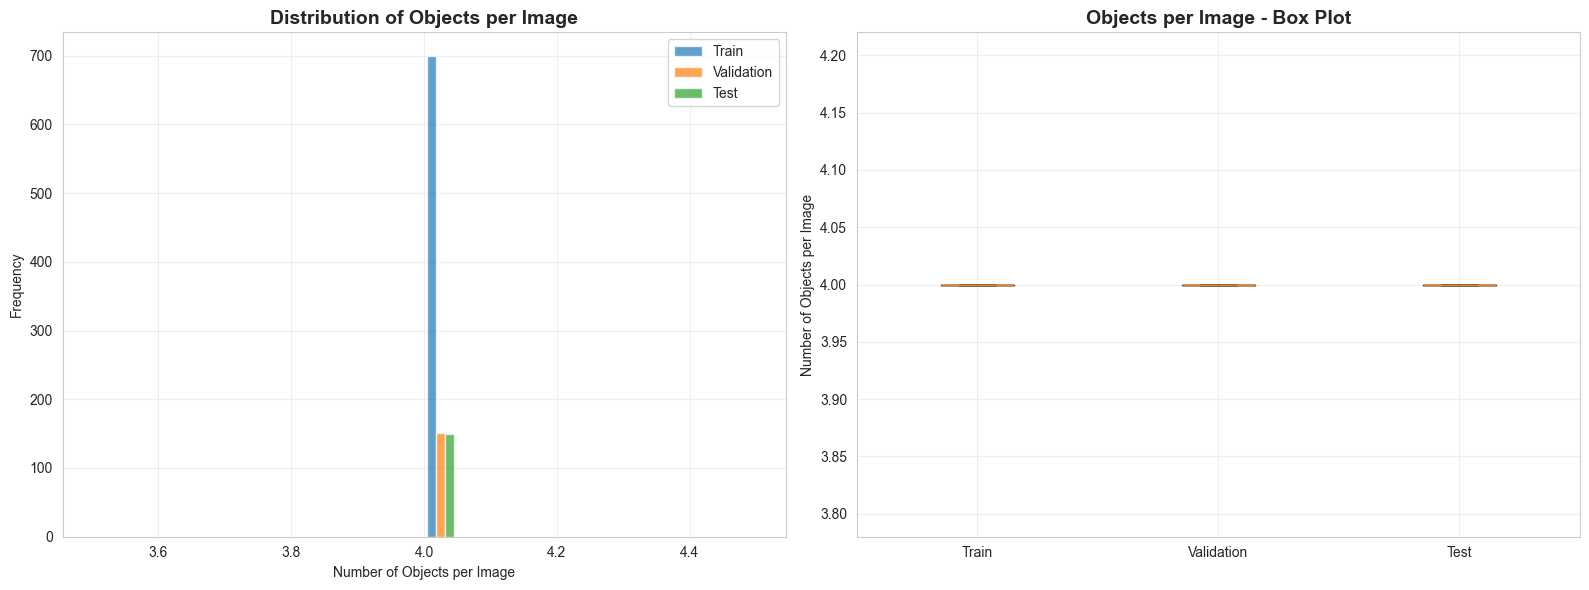

In [9]:
# Visualize objects per image distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist([train_obj_counts, valid_obj_counts, test_obj_counts], 
            label=['Train', 'Validation', 'Test'], bins=20, alpha=0.7)
axes[0].set_xlabel('Number of Objects per Image')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [train_obj_counts, valid_obj_counts, test_obj_counts]
axes[1].boxplot(box_data, labels=['Train', 'Validation', 'Test'])
axes[1].set_ylabel('Number of Objects per Image')
axes[1].set_title('Objects per Image - Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()